In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from finx_option_pricer.option import Option
from finx_option_pricer.option_plot import OptionsPlot, OptionPosition
from finx_option_pricer.option_structures import gen_calendar

import matplotlib

Goal = understand the edge in buying a 3d calendar where,
- (short) frontside = Friday ATM call/put at higher vol
- (long)  backside  = Monday ATM call/put at lower vol

In [4]:
def gen_df(spot_price, strike_price, base_vol, spot_range, days, increment_days=1):
    fs = base_vol 
    bs = base_vol
    fsf = fs
    bsf = bs

    kwargs = dict(
        spot_price=spot_price, 
        strike_price=strike_price,
        front_days=days, 
        front_vol=fs,
        front_vol_final=fsf,
        back_vol=bs,
        back_vol_final=bsf,
        option_type='c',
    )
    # this generates a list of Option Positions
    cal = gen_calendar(**kwargs)

    op_plot = OptionsPlot(
        option_positions=cal,
        strike_interval=5,
        spot_range=spot_range)

    # strikes = [op.option.K for op in op_plot.option_positions]
    df = op_plot.gen_value_df_timeincrementing(days, increment_days, value_relative=False)
    df.set_index("strikes", inplace=True)

    # set time incrementing columns
    columns = [f"t{i}" for i, _ in enumerate(df.columns)]
    columns[-1] = "tf"
    df.columns = columns
    
    return df

spot_price = 4100.0
strike_price = 4100.0

spot_range_distance = 500
spot_range = [
    spot_price - spot_range_distance, 
    spot_price + spot_range_distance,
]

base_vol = 0.25

days = 10
increment_days = 2

df = gen_df(
    spot_price,
    strike_price,
    base_vol,
    spot_range,
    days,
    increment_days
)

In [5]:
intial_price = df.loc[spot_price]["t0"]

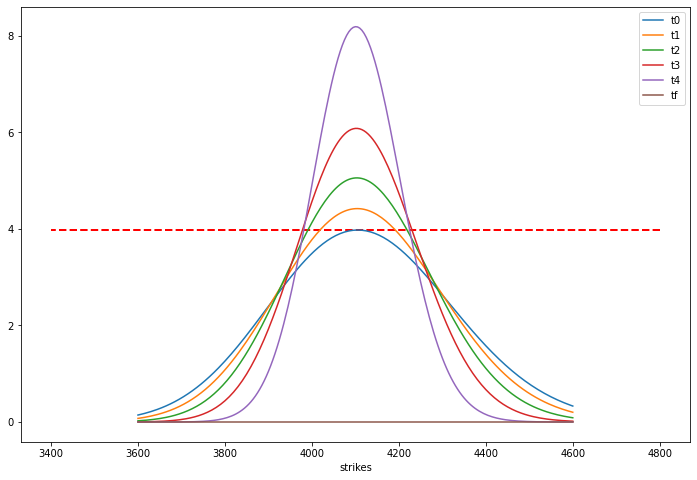

In [6]:
#
# plot ref data. mins and maxs
#
vlines_ymin = df.min().min()
vlines_ymax = df.max().max()
hlines_xmax = spot_range[0]-200
hlines_xmin = spot_range[1]+200

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

# plot the expected PnL
df.plot(figsize=(12, 8))
# plt.hlines(0, hlines_xmin, hlines_xmax, color="grey", linewidth=0.5, linestyles="-")

intial_price = df.loc[spot_price]["t0"]
matplotlib.pyplot.hlines(intial_price, hlines_xmin, hlines_xmax, color="red", linewidth=2, linestyles="--")
# matplotlib.pyplot.hlines(-5, hlines_xmin, hlines_xmax, color="blue", linewidth=1, linestyles="--")

# add spot price 
# matplotlib.pyplot.vlines(spot_price, ymax=vlines_ymax, ymin=vlines_ymin, colors="black", linestyles="--", linewidth=1.2)

# #
# # let's add some extrapolations
# #
# # with VIX at 20, where would a 1.2 sigma move in spot ocurr within 2/3 of the remaining DTE time?
# #
# import math
# sigma = 1.0
# vix_percent = 0.25
# move_days = days*0.4
# expected_move_percent = sigma * vix_percent * math.sqrt(move_days/MARKET_DAYS_PER_YEAR)
# spot_delta = spot_price * expected_move_percent
# spot_min, spotincrement_daysx = spot_price - spot_delta, spot_price + spot_delta
# print(f"{sigma}sigma expected move +/- {spot_delta:0.2f} ({100*expected_move_percent:0.2f}%) ... [{spot_min:0.0f}, {spot_max:0.0f}]")


# # plot the spot_min, and spot_max
# # matplotlib.pyplot.vlines(spot_min, ymax=df.max().max(), ymin=df.min().min(), colors="red", linestyles="--", linewidth=1.2)
# # matplotlib.pyplot.vlines(spot_max, ymax=df.max().max(), ymin=df.min().min(), colors="red", linestyles="--", linewidth=1.2)
# # matplotlib.pyplot.vlines(strike_price, ymax=df.max().max(), ymin=df.min().min(), colors="green", linewidth=2)

In [7]:
df.head(10_0000).reset_index().melt(id_vars=["strikes"])

,strikes,variable,value
0,3600.0,t0,0.144821
1,3605.0,t0,0.155251
2,3610.0,t0,0.166295
3,3615.0,t0,0.177977
4,3620.0,t0,0.190323
...,...,...,...
1201,4580.0,tf,0.000000
1202,4585.0,tf,0.000000
1203,4590.0,tf,0.000000
1204,4595.0,tf,0.000000


In [ ]:
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
from dash import html
import pandas as pd
import plotly.express as px

app = dash.Dash()
app.layout = html.Div(children = [
    html.H1(children='Dash trail'),
    html.Br(),
    html.Br(),

    html.Label("Increment Days"),
    dcc.Input(id='id_input_increment_days', value='1', debounce=True, type='number', min=1, max=10, step=1),
    html.Br(),
    html.Br(),
    
    html.Label("DTE, days"),
    dcc.Input(id='id_input_dte', value='1', debounce=True, type='number', min=2, max=10, step=1),
    html.Br(),
    
    dcc.Graph(id='inflow_graph')
])

@app.callback(
    Output('inflow_graph', 'figure'),
    Input('id_input_increment_days', 'value'),
    Input('id_input_dte', 'value'),
)
def update_graph(increment_days, dte):
    
    spot_price = 4100.0
    strike_price = 4100.0
    spot_range_distance = 500
    spot_range = [
        spot_price - spot_range_distance, 
        spot_price + spot_range_distance,
    ]

    base_vol = 0.25
    
    days = int(dte)

    # only UI driven input
    increment_days = int(increment_days)
        
    df = gen_df(
        spot_price,
        strike_price,
        base_vol,
        spot_range,
        days,
        increment_days
    )
    
    msg = f"""gen_df(spot_price, strike_price, base_vol, spot_range, days={days}, increment_days={increment_days})"""
    print(msg)

    
    gdf = df.reset_index().melt(id_vars=["strikes"])
    # gdf looks like this
    # strikes	variable	value
    # 0	3600.0	t0	0.144821
    # 1	3605.0	t0	0.155251    
    
    fig = px.line(gdf, x="strikes", y="value", color='variable')
    return fig

app.run_server(debug=True, use_reloader=False) # Turn off reloader if inside Jupyter